# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os

####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.9
"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
# LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 100000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 3000
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    
if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_256_SGD_90'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  45000
- Length of Valid Set :  5000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if SPLIT_RATIO != 0:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
elif SPLIT_RATIO == 0:
    valid_dataloader = None

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

train.transforms = Compose(
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 256
valid.transforms = ToTensor() 256
test.transforms = ToTensor() 256


## Confirm that the dataset is loaded properly

In [6]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([0.4910, 0.4816, 0.4413])
Shape of y: torch.Size([256]) torch.int64


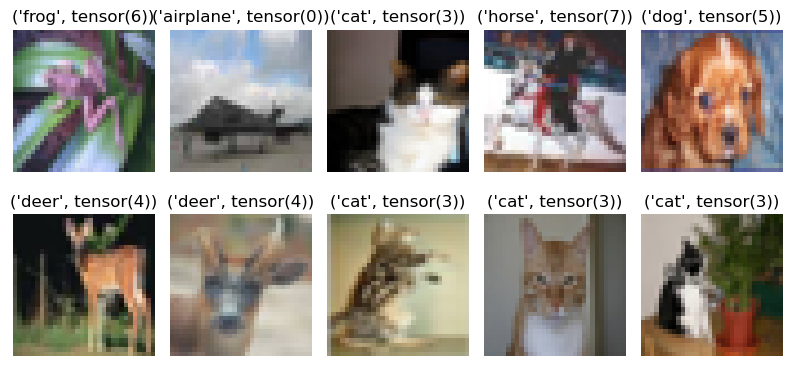

In [7]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

## Model Confirm

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES,
        num_layer_factor=NUM_LAYERS_LEVEL,
        Downsample_option="A",
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(
        num_classes=COUNT_OF_CLASSES, 
        Downsample_option="A"
    ).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")


ResNet-32 for CIFAR10 is loaded.


In [10]:
model.named_modules

<bound method Module.named_modules of MyResNet_CIFAR(
  (single_conv32block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv32blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv

In [11]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 0.464M                 | 18.018G    |
|  single_conv32block            |  0.464K                |  0.134G    |
|   single_conv32block.0         |   0.432K               |   0.113G   |
|    single_conv32block.0.weight |    (16, 3, 3, 3)       |            |
|   single_conv32block.1         |   32                   |   20.972M  |
|    single_conv32block.1.weight |    (16,)               |            |
|    single_conv32block.1.bias   |    (16,)               |            |
|  conv32blocks                  |  23.36K                |  6.25G     |
|   conv32blocks.0               |   4.672K               |   1.25G    |
|    conv32blocks.0.conv1        |    2.304K              |    0.604G  |
|    conv32blocks.0.bn1          |    32                  |    20.972M |
|    conv32blocks.0.conv2        |    2.304K       

# Define Training

## (1) Define Criterion

In [12]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [13]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## (3) Define Early Stopping

In [14]:
class EarlyStopper:
    def __init__(self, patience, model, file_path):
        self.best_eval_loss = float("inf")
        self.early_stop_counter = 0
        self.PATIENCE = patience
        self.file_path = file_path
        self.model = model
        pass

    def check(self, eval_loss):
        if eval_loss < self.best_eval_loss:
            self.best_eval_loss = eval_loss
            self.early_stop_counter = 0
            print("updated best eval loss :", self.best_eval_loss)
            torch.save(self.model.state_dict(), "models/" + self.file_path + ".pth")
            return False
        else:
            self.early_stop_counter += 1
            if self.early_stop_counter >= self.PATIENCE:
                print(f"Early stop!! best_eval_loss = {self.best_eval_loss}")
                return True
                
    def state_dict(self):
        return {"best_eval_loss": self.best_eval_loss, "early_stop_counter": self.early_stop_counter}
    
    def load_state_dict(self, state_dict):
        self.best_eval_loss = state_dict["best_eval_loss"]
        self.early_stop_counter = state_dict["early_stop_counter"]
        
        return
    
earlystopper = EarlyStopper(EARLYSTOPPINGPATIENCE, model, file_path)

## (4) Define Learning Rate schedualer

In [15]:
scheduler_mapping = {"CIFAR10": 1000, "CIFAR100": 1000, "ImageNet2012": 30}

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    cooldown=100
)

## (5) Define AMP scaler

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [17]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [18]:
optimizer.param_groups[0]["lr"]

0.1

# [Training Loop]

In [19]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/100000] :


100%|██████████| 176/176 [00:08<00:00, 19.59it/s]

Train Loss: 0.0130 | Train Acc: 11.50%


Valid Loss: 2.2943 | Valid Acc: 10.66%
Test  Loss: 2.3029 | Test Acc: 10.12%
updated best eval loss : 2.2942792415618896
--------------------------------------------------
[Epoch 2/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.39it/s]


Train Loss: 0.0126 | Train Acc: 14.00%
Valid Loss: 2.2231 | Valid Acc: 16.50%
Test  Loss: 2.3048 | Test Acc: 11.01%
updated best eval loss : 2.2231091499328612
--------------------------------------------------
[Epoch 3/100000] :


100%|██████████| 176/176 [00:08<00:00, 19.93it/s]


Train Loss: 0.0110 | Train Acc: 31.50%
Valid Loss: 2.1469 | Valid Acc: 20.32%
Test  Loss: 2.2486 | Test Acc: 17.40%
updated best eval loss : 2.1469210624694823
--------------------------------------------------
[Epoch 4/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.42it/s]


Train Loss: 0.0110 | Train Acc: 28.50%
Valid Loss: 1.8621 | Valid Acc: 29.72%
Test  Loss: 1.8281 | Test Acc: 32.20%
updated best eval loss : 1.8620677769184113
--------------------------------------------------
[Epoch 5/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.30it/s]


Train Loss: 0.0097 | Train Acc: 37.00%
Valid Loss: 2.0080 | Valid Acc: 29.54%
Test  Loss: 1.7865 | Test Acc: 34.76%
--------------------------------------------------
[Epoch 6/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.41it/s]


Train Loss: 0.0080 | Train Acc: 49.00%
Valid Loss: 1.5707 | Valid Acc: 43.58%
Test  Loss: 1.4245 | Test Acc: 49.51%
updated best eval loss : 1.5707234919071198
--------------------------------------------------
[Epoch 7/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.34it/s]


Train Loss: 0.0073 | Train Acc: 53.00%
Valid Loss: 1.6465 | Valid Acc: 42.36%
Test  Loss: 1.3148 | Test Acc: 53.26%
--------------------------------------------------
[Epoch 8/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.85it/s]


Train Loss: 0.0074 | Train Acc: 53.00%
Valid Loss: 1.3043 | Valid Acc: 54.42%
Test  Loss: 1.0373 | Test Acc: 63.21%
updated best eval loss : 1.304285705089569
--------------------------------------------------
[Epoch 9/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.61it/s]


Train Loss: 0.0068 | Train Acc: 58.00%
Valid Loss: 1.4104 | Valid Acc: 50.68%
Test  Loss: 1.1355 | Test Acc: 61.37%
--------------------------------------------------
[Epoch 10/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.40it/s]


Train Loss: 0.0057 | Train Acc: 62.50%
Valid Loss: 1.4537 | Valid Acc: 49.92%
Test  Loss: 1.3987 | Test Acc: 56.37%
--------------------------------------------------
[Epoch 11/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.69it/s]


Train Loss: 0.0057 | Train Acc: 67.00%
Valid Loss: 1.0763 | Valid Acc: 62.04%
Test  Loss: 0.8485 | Test Acc: 70.38%
updated best eval loss : 1.076333448290825
--------------------------------------------------
[Epoch 12/100000] :


100%|██████████| 176/176 [00:08<00:00, 19.87it/s]


Train Loss: 0.0054 | Train Acc: 68.50%
Valid Loss: 1.1581 | Valid Acc: 59.44%
Test  Loss: 0.8269 | Test Acc: 71.10%
--------------------------------------------------
[Epoch 13/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.37it/s]


Train Loss: 0.0060 | Train Acc: 67.50%
Valid Loss: 0.9870 | Valid Acc: 65.88%
Test  Loss: 0.7352 | Test Acc: 74.77%
updated best eval loss : 0.9869827449321746
--------------------------------------------------
[Epoch 14/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.35it/s]


Train Loss: 0.0054 | Train Acc: 70.50%
Valid Loss: 1.0420 | Valid Acc: 62.94%
Test  Loss: 0.8091 | Test Acc: 71.60%
--------------------------------------------------
[Epoch 15/100000] :


100%|██████████| 176/176 [00:08<00:00, 19.67it/s]


Train Loss: 0.0053 | Train Acc: 65.50%
Valid Loss: 1.0003 | Valid Acc: 65.12%
Test  Loss: 0.7685 | Test Acc: 73.68%
--------------------------------------------------
[Epoch 16/100000] :


100%|██████████| 176/176 [00:08<00:00, 19.85it/s]


Train Loss: 0.0053 | Train Acc: 66.00%
Valid Loss: 1.0035 | Valid Acc: 65.90%
Test  Loss: 0.7549 | Test Acc: 75.38%
--------------------------------------------------
[Epoch 17/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.74it/s]


Train Loss: 0.0053 | Train Acc: 65.00%
Valid Loss: 0.9553 | Valid Acc: 66.02%
Test  Loss: 0.6880 | Test Acc: 77.02%
updated best eval loss : 0.9553061813116074
--------------------------------------------------
[Epoch 18/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.11it/s]


Train Loss: 0.0055 | Train Acc: 64.00%
Valid Loss: 0.9499 | Valid Acc: 67.00%
Test  Loss: 0.7090 | Test Acc: 76.70%
updated best eval loss : 0.9498755306005477
--------------------------------------------------
[Epoch 19/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.43it/s]


Train Loss: 0.0045 | Train Acc: 68.00%
Valid Loss: 0.9006 | Valid Acc: 69.26%
Test  Loss: 0.6117 | Test Acc: 78.79%
updated best eval loss : 0.9005964905023575
--------------------------------------------------
[Epoch 20/100000] :


100%|██████████| 176/176 [00:08<00:00, 20.46it/s]


Train Loss: 0.0041 | Train Acc: 73.50%
Valid Loss: 0.9536 | Valid Acc: 67.32%
Test  Loss: 0.7418 | Test Acc: 76.47%
--------------------------------------------------
[Epoch 21/100000] :


 29%|██▉       | 51/176 [00:02<00:06, 18.57it/s]

In [ ]:
view = LogViewer(logs)
view.draw()

In [ ]:
view.print_all()

In [ ]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))